# Описание проекта
По представленным данным необходимо провести исследовательский анализ предсказания возраста моллюска `галиотиса` (он же *морское ушко*). Необходимо провести однофакторный анализ, построить матрицу корреляций и пр. Также необходимо в ходе выполнения проекта использовать разные библиотеки обработки данных для сравнения скорости их работы.

# Исходные данные

Предскажите возраст морского ушка по физическим измерениям

* `Sex` - пол моллюска - номинальный - `M`, `F` и `I` (*infant*)

* `Lenght` - измерение длины раковины в мм - непрерывная

* `Diameter` - диаметр (перпендикулярно длине) в мм - непрерывный

* `Height` - высота (с мясом в раковине) в мм - непрерывная

* `Whole weight` - масса целого моллюска в граммах - непрерывный

* `Shucked weight` - масса очищенного моллюска (мясо) в граммах - непрерывный

* `Viscera weight` - масса потрохов (после обескровливания) в граммах - непрерывный

* `Shell weight` - масса скорлупы (вес моллюска после высушивания) в граммах - непрерывный

* `Rings` - кольца (+1.5 дает возраст в годах) - целое число - целевой признак

# Выполнение исследовательского проекта

## Порядок и критерии успешной реализации проекта

В рамках проекта необходимо реализовать следующие пункты:
1.  [Общее исследование данных](#Общее-исследование-данных) (**1 балл**):
  * проверить размеры таблицы,
  * число столбцов,
  * количество пропусков в столбцах.
2.  [Однофакторный анализ](#Однофакторный-анализ) (**3 балла**):
  * по каждому столбцу посмотреть его распределение,
  * если есть пропуски и ошибочные значения - обработать их,
  * посмотреть связь с целевой переменной .
3.  [Построить матрицу корреляций](#Построение-матрицы-корреляций) (или ее аналог для категориальных признаков)  (**2 балла**):
  * использовать корреляции,
  * тест `χ2χ2`,
  * `ANOVA`.
4.  [Провести анализ целевой переменной](#Анализ-целевой-переменной) (**1 балл**):
  * на какое распределение больше всего похожа ее гистограмма?
  * какие проблемы в связи с этим могут возникнуть при обучении моделей?
5.  Увеличить размер данных простым дублированием до *1_000_000* строк в датасете. Провести [сравнение скорости работы](#Сравнение-библиотек) `Pandas` и `Polars` на увеличенном датасете по параметрам:
  * загрузка данных (**1 балл**)
  * фильтрация данных (**1 балл**)
  * агрегация данных (**1 балл**).


## Общее исследование данных
Выполним общее исследование данных согласно плану

### Импорт библиотек
Вначале выполним импорт библиотек, используемых в рамках проекта

In [1]:
!pip install polars
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import chi2_contingency
from scipy.stats import f_oneway
import scipy.stats as stats
import polars as pl

Defaulting to user installation because normal site-packages is not writeable


### Открытие датасета
Откроем датасет и просмотрим первые строки

In [2]:
abalone_url = 'https://raw.githubusercontent.com/aiedu-courses/stepik_eda_and_dev_tools/main/datasets/abalone.csv'
data = pd.read_csv(abalone_url)
data.head()

,Sex,Length,Diameter,Height,Whole weight,Shucked weight,Viscera weight,Shell weight,Rings
0,M,0.455,0.365,0.095,0.5140,0.2245,0.1010,0.150,15
1,M,0.350,0.265,0.090,0.2255,0.0995,0.0485,0.070,7
2,F,0.530,0.420,0.135,0.6770,0.2565,0.1415,0.210,9
3,M,0.440,0.365,0.125,NaN,0.2155,0.1140,0.155,10
4,I,0.330,0.255,0.080,0.2050,0.0895,0.0395,0.055,7


Уже по первым пяти строкам видно, что в датасете присутствуют пропуски. 

Подсчитаем, сколько в датасете строк и столбцов, а также какие типы данных у признаков.

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4177 entries, 0 to 4176
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Sex             4177 non-null   object 
 1   Length          4177 non-null   float64
 2   Diameter        4078 non-null   float64
 3   Height          4177 non-null   float64
 4   Whole weight    4078 non-null   float64
 5   Shucked weight  4177 non-null   float64
 6   Viscera weight  4177 non-null   float64
 7   Shell weight    4127 non-null   float64
 8   Rings           4177 non-null   int64  
dtypes: float64(7), int64(1), object(1)
memory usage: 293.8+ KB


In [4]:
data.shape

(4177, 9)

Как видно, датасет содержит немногим более 4К строк (достаточно немного) и 9 столбцов-признаков, как и обозначено в разделе [Исходные данные](#Исходные-данные). У всех признаков, кроме двух, тип данных float64, т.е. имеем типичный пример количественные данные. Признак `Sex` относится к качественным; содержит не только данные о поле моллюска, но и его _возрасте_. Признак `Rings` по описанию датасета является целевым и целочисленным. 

### Приведение столбцов к нижнему регистру
Ввиду того, что в названиях признаков содержатся буквы в разных регистрах, а между словами присутствуют пробелы, в дальнейшем это может привести к сложностям (а может и не привести конечно) при обработке данных.

In [5]:
# Приводим названия столбцов к нижнему регистру
data.columns = data.columns.str.lower()

# Заменяем пробелы на нижние подчеркивания
data.columns = data.columns.str.replace(' ', '_')

data.columns

Index(['sex', 'length', 'diameter', 'height', 'whole_weight', 'shucked_weight',
       'viscera_weight', 'shell_weight', 'rings'],
      dtype='object')

### Определение и обработка пропусков
Уже по первым строкам видно, что в датасете имеются пропуски. Выполним анализ всех признаков.

In [6]:
data.isnull().sum().sort_values(ascending=False)

diameter          99
whole_weight      99
shell_weight      50
sex                0
length             0
height             0
shucked_weight     0
viscera_weight     0
rings              0
dtype: int64

На первый взгляд, пропусков немного, а двойное упоминание числа 99 у двух признаков наводит на мысль, что они могут дублироваться в одних и тех же строках. Выведем случайные 10 строк для пропусков в признаке `Whole weight`. 

In [7]:
data[data['whole_weight'].isnull()].sample(10)

,sex,length,diameter,height,whole_weight,shucked_weight,viscera_weight,shell_weight,rings
1420,F,0.710,0.550,0.170,NaN,0.7430,0.3450,0.4500,11
3382,M,0.495,0.400,0.120,NaN,0.2605,0.1610,0.1900,15
1167,M,0.620,0.470,0.135,NaN,0.5315,0.2005,0.2475,8
2446,F,0.550,0.435,0.170,NaN,0.2875,0.1645,0.2800,14
2776,M,0.585,0.465,0.165,NaN,0.4025,0.1625,0.2740,10
2016,M,0.505,0.390,0.120,NaN,0.3315,0.1385,0.1670,9
2987,M,0.555,0.405,0.190,NaN,0.6115,0.3420,0.3890,10
749,M,0.695,0.515,0.175,NaN,0.5780,0.4105,0.3900,15
275,M,0.655,0.540,0.215,NaN,0.7425,0.3270,0.5850,22
1471,f,0.530,0.400,0.125,NaN,0.3980,0.1510,0.1750,8


Получаем результат, который нельзя однозначно охарактеризовать. Поэтому подсчитаем, сколько всего пропусков присутствует от общего количества строк. 

In [8]:
total_missing_rows = data[['diameter', 'whole_weight', 'shell_weight']].isnull().any(axis=1).sum()
print(f'Пропуски содержатся в {round(100 * total_missing_rows / data.shape[0], 2)} процентах строк от общего числа')

Пропуски содержатся в 5.79 процентах строк от общего числа


В целом избавиться от чуть более 5 процентов строк было бы вполне оправдано, если их природа более ясна. Сейчас же можно поступить иначе. Для признака `Shell weight` удалим все строки, поскольку они составляют чуть более 1% от общего числа строк. А для признаков `Diameter` и `Whole weight` используем метод линейной интерполяции для более _плавного_ заполнения пропусков. 

In [9]:
data.dropna(subset=['shell_weight'], inplace=True)
data.interpolate(method='linear', inplace=True)
print(f'осталось {data.isnull().sum().sort_values(ascending=False).sum()} пропусков\nосталось {data.shape[0]} строк в датасете')

осталось 0 пропусков
осталось 4127 строк в датасете


## Однофакторный анализ

### Определение и обработка уникальных значений
Хоть это и не требуется напрямую в рамках проекта напрямую, но для качественного признака (а он у нас единственный в датасете) можно рассмотреть, соответствует ли описанию данных имеющиеся значения.

In [10]:
data['sex'].value_counts()

M    1432
I    1254
F    1248
f     193
Name: sex, dtype: int64

Действительно в датасете для обозначения пола моллюска встречаются заглавное `F` и строчное описание `f`. Меж тем, в описании исходных данных фигурирует только верхний регистр. Возможно это и не скажется в дальнейшем, но, на всякий случай, приведём такие значения к единому верхнему регистру.

In [11]:
data['sex'] = data['sex'].str.upper()
data['sex'].value_counts()

F    1441
M    1432
I    1254
Name: sex, dtype: int64

### Построение графиков распределения по каждому из признаков
Для каждого из признаков построим графики распределений, дабы выявить возможные закономерности. Но прежде выведем сводную информацию по распределениям каждого из признаков.

In [12]:
data.describe()

,length,diameter,height,whole_weight,shucked_weight,viscera_weight,shell_weight,rings
count,4127.000000,4127.000000,4127.000000,4127.000000,4127.000000,4127.000000,4127.000000,4127.000000
mean,0.524385,0.408093,0.139629,0.829084,0.359730,0.180778,0.239072,9.942573
std,0.119749,0.098791,0.041782,0.488305,0.221384,0.109297,0.138942,3.225091
min,0.075000,0.055000,0.000000,0.002000,0.001000,0.000500,0.001500,1.000000
25%,0.450000,0.350000,0.115000,0.442500,0.187000,0.094000,0.130000,8.000000
50%,0.545000,0.425000,0.140000,0.799500,0.336000,0.171000,0.235000,9.000000
75%,0.615000,0.480000,0.165000,1.151000,0.502000,0.252750,0.328250,11.000000
max,0.815000,0.650000,1.130000,2.825500,1.488000,0.760000,1.005000,29.000000


Беглый взгляд наблюдает либо выбивающиеся значения.

#### График плотности распределения длин раковин моллюска
На этом и дальнейшем графиках при увеличении числа `bins` красная линия будет смещаться всё ближе к оси `X`. Намеренно не применял распеределение из библиотеки `seaborn`, хоть это и было короче с т.зрения кода, но при этом вряд ли бы получилось указать разноцветную апроксимацию плотности распределения поверх гистограммы. 

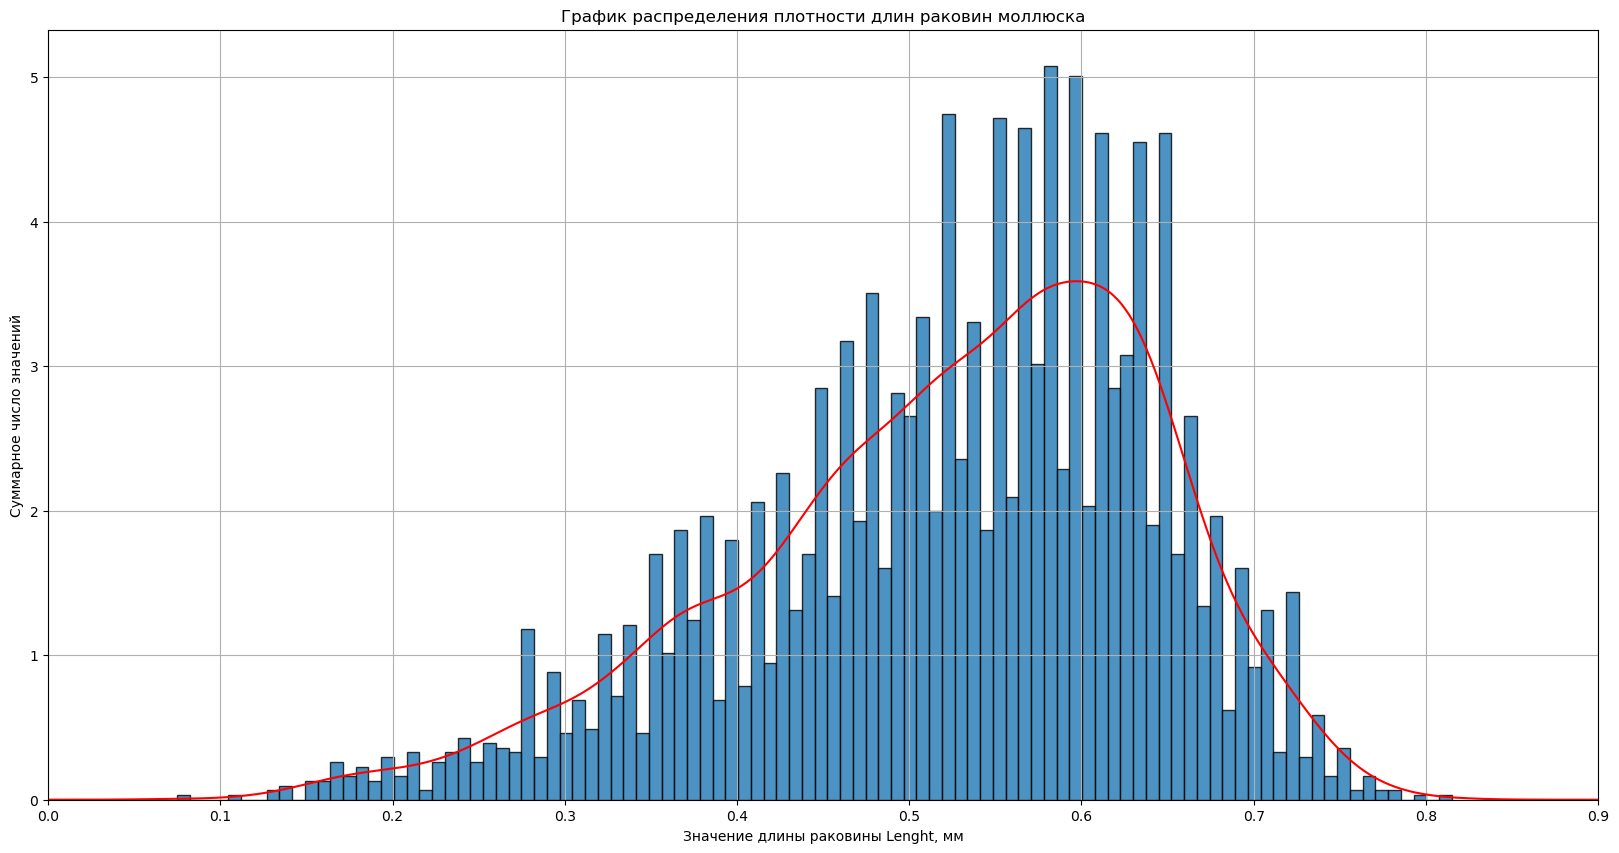

In [13]:
plt.figure(figsize=(20,10))
data['length'].plot(
    kind='hist', 
    density=True, 
    alpha=0.8, 
    bins=100, 
    edgecolor='black'
                   )
data['length'].plot(
    kind='density', 
    color='red'
                   )
plt.title('График распределения плотности длин раковин моллюска')
plt.xlim(0, 0.9)
plt.xlabel('Значение длины раковины Lenght, мм')
plt.ylabel('Суммарное число значений')
plt.grid(True)
plt.show()

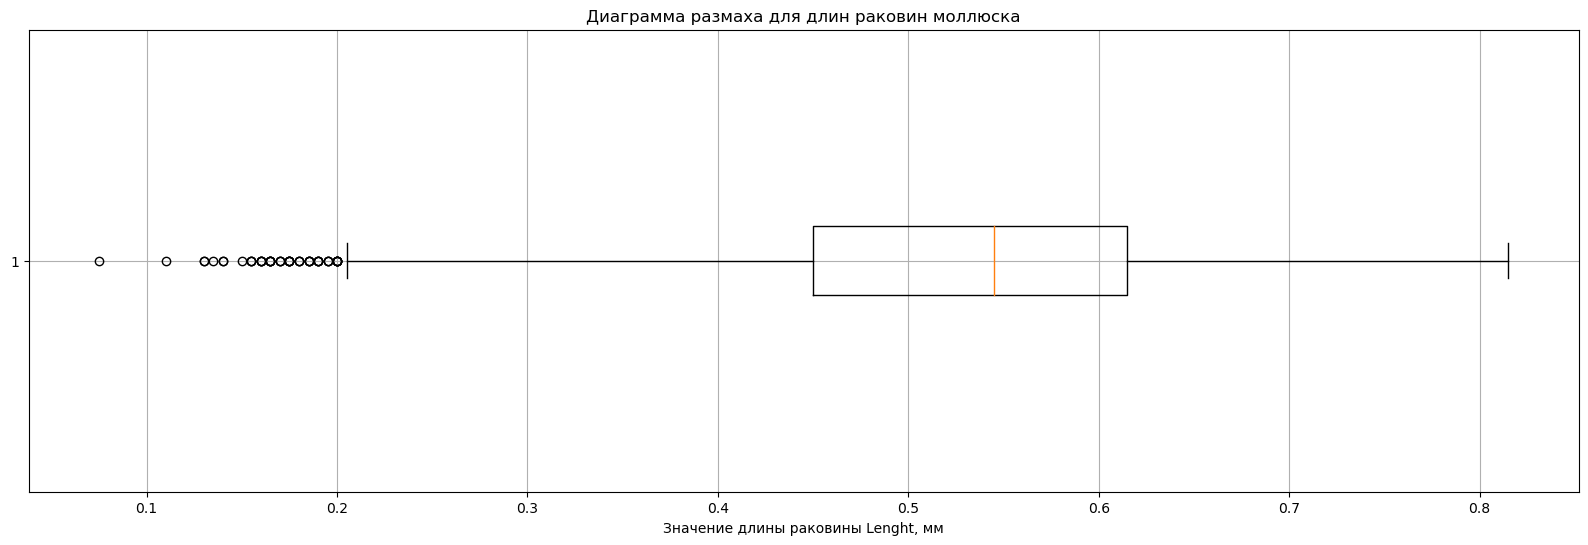

In [14]:
plt.figure(figsize=(20, 6))
plt.boxplot(data['length'], vert=False)
plt.title('Диаграмма размаха для длин раковин моллюска')
plt.xlabel('Значение длины раковины Lenght, мм')
plt.grid(True)
plt.show()

На основании построенных графиков можно сделать следующие выводы:
1. общее число моллюсков возрастает до 0.55 мм, являющегося медианным значением.
2. плотность распределения нельзя однозначно назвать равномерной, скорее, она нормальная.
3. на диаграмме размаха более чётко, в отличие от гистограммы распределения плотности, наблюдаются выбросы, не попадающие в нижнюю границу. При расчёте получаем число выбросов около 1,5%. Избавимся от всех значений, менее 0,21 мм. 

In [15]:
# процент выбросов от общего числа строк в датасете
100 * len(data[data['length'] <= 0.21]) / data.shape[0]

1.4296098861158226

In [16]:
#data_cl = data[data['length'] >= 0.21]

#### График плотности распределения диаметра раковин моллюска

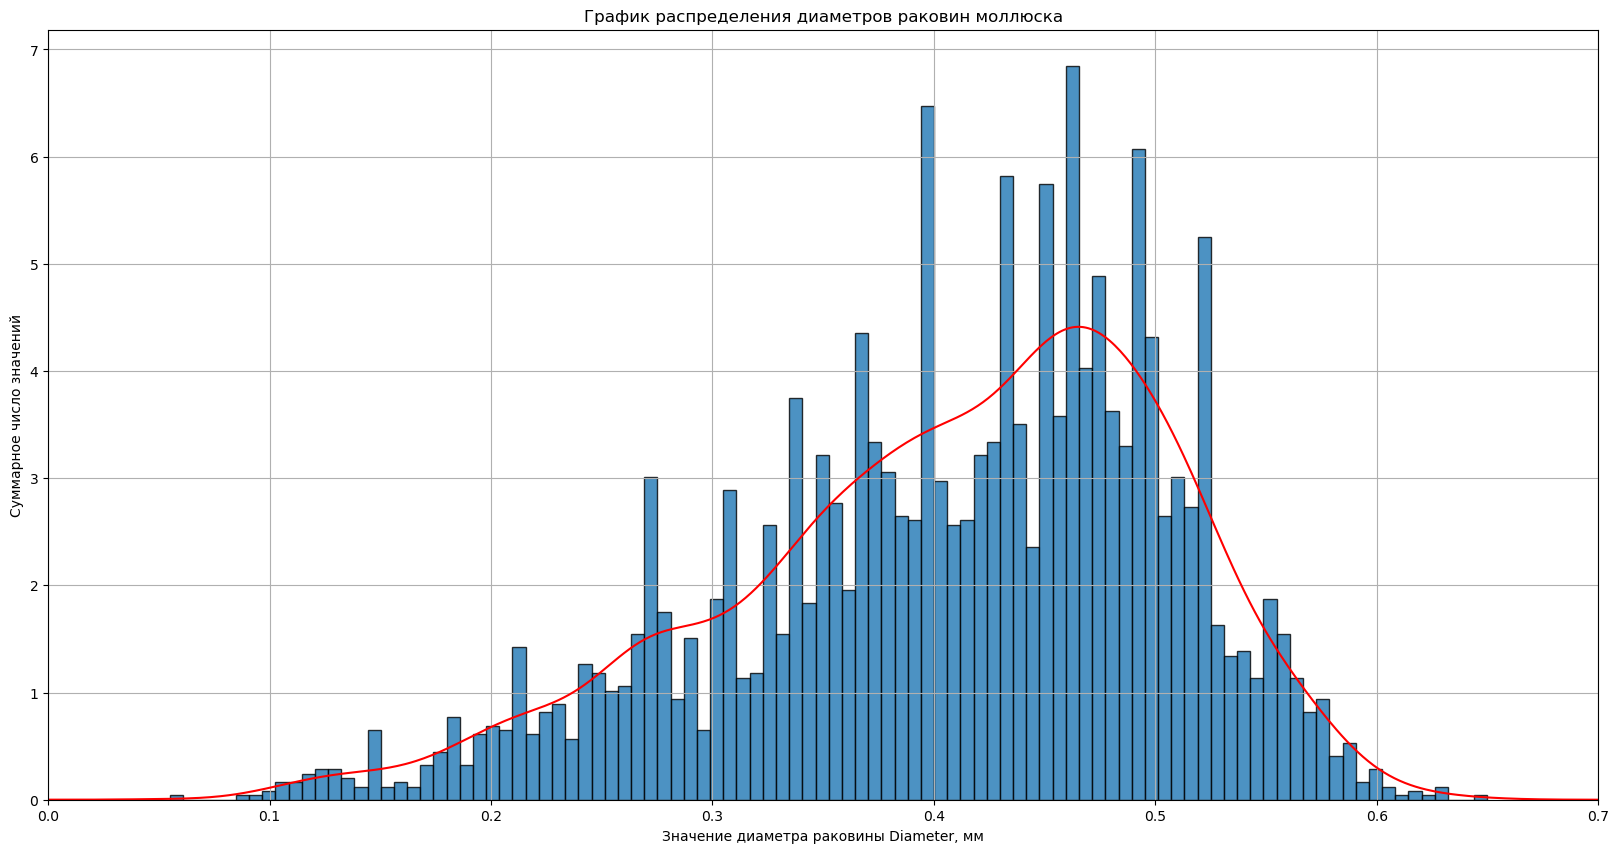

In [17]:
plt.figure(figsize=(20,10))
data['diameter'].plot(
    kind='hist', 
    density=True, 
    alpha=0.8, 
    bins=100, 
    edgecolor='black'
                   )
data['diameter'].plot(
    kind='density', 
    color='red'
                   )
plt.title('График распределения диаметров раковин моллюска')
plt.xlim(0, 0.7)
plt.xlabel('Значение диаметра раковины Diameter, мм')
plt.ylabel('Суммарное число значений')
plt.grid(True)
plt.show()

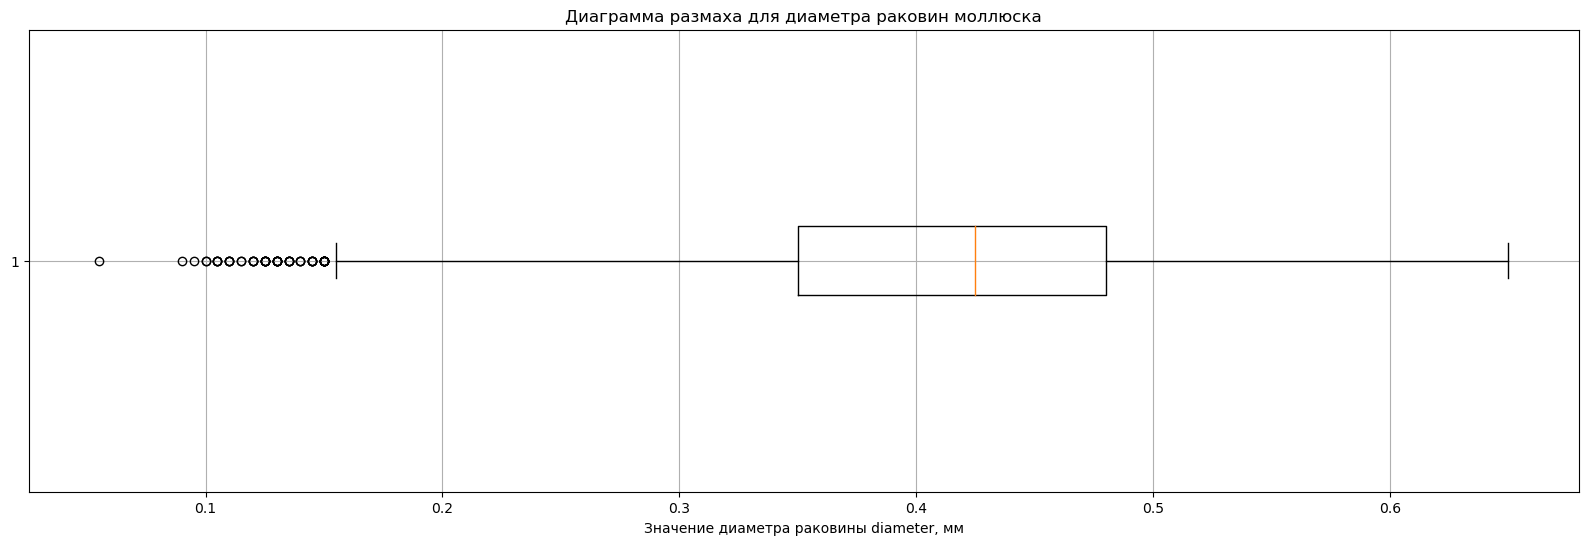

In [18]:
plt.figure(figsize=(20, 6))
plt.boxplot(data['diameter'], vert=False)
plt.title('Диаграмма размаха для диаметра раковин моллюска')
plt.xlabel('Значение диаметра раковины diameter, мм')
plt.grid(True)
plt.show()

In [19]:
# процент выбросов от общего числа строк в датасете
100 * len(data[data['diameter'] <= 0.155]) / data.shape[0]

1.4538405621516841

Выводы:
1. плотность распределения неравномерна, однако замещение достаточно плавное.
2. число выбросов составляет даже менее полпроцента от числа строк очищаемого датасета, что можно считать хорошим результатом.

#### График плотности распределения высоты раковин моллюска

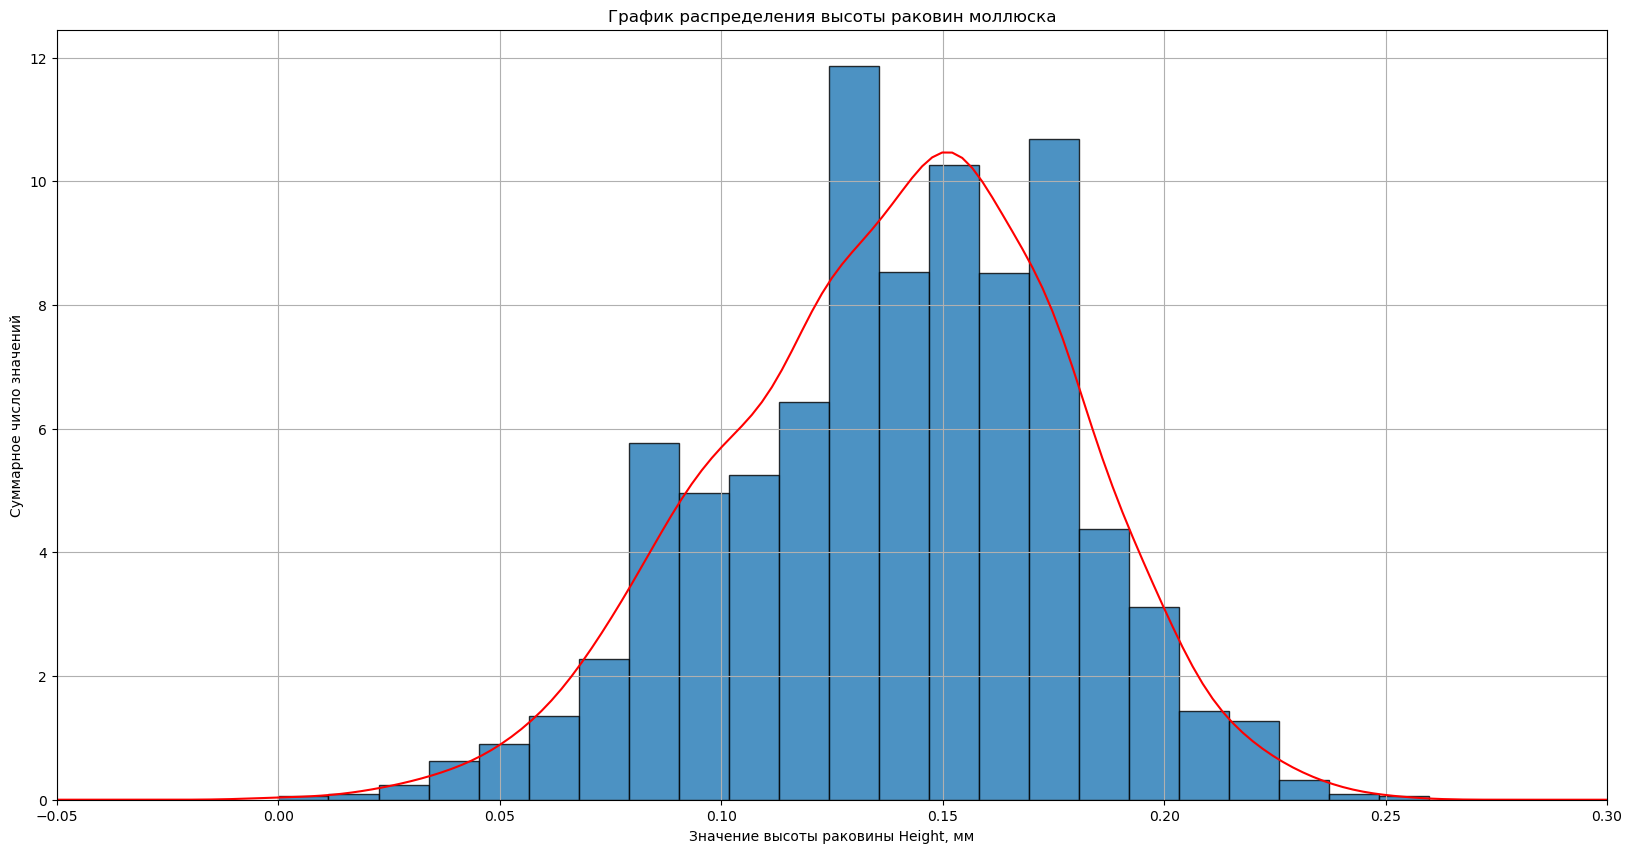

In [20]:
plt.figure(figsize=(20,10))
data['height'].plot(
    kind='hist', 
    density=True, 
    alpha=0.8, 
    bins=100, 
    edgecolor='black'
                   )
data['height'].plot(
    kind='density', 
    color='red'
                   )
plt.title('График распределения высоты раковин моллюска')
plt.xlim(-0.05, 0.3)
plt.xlabel('Значение высоты раковины Height, мм')
plt.ylabel('Суммарное число значений')
plt.grid(True)
plt.show()

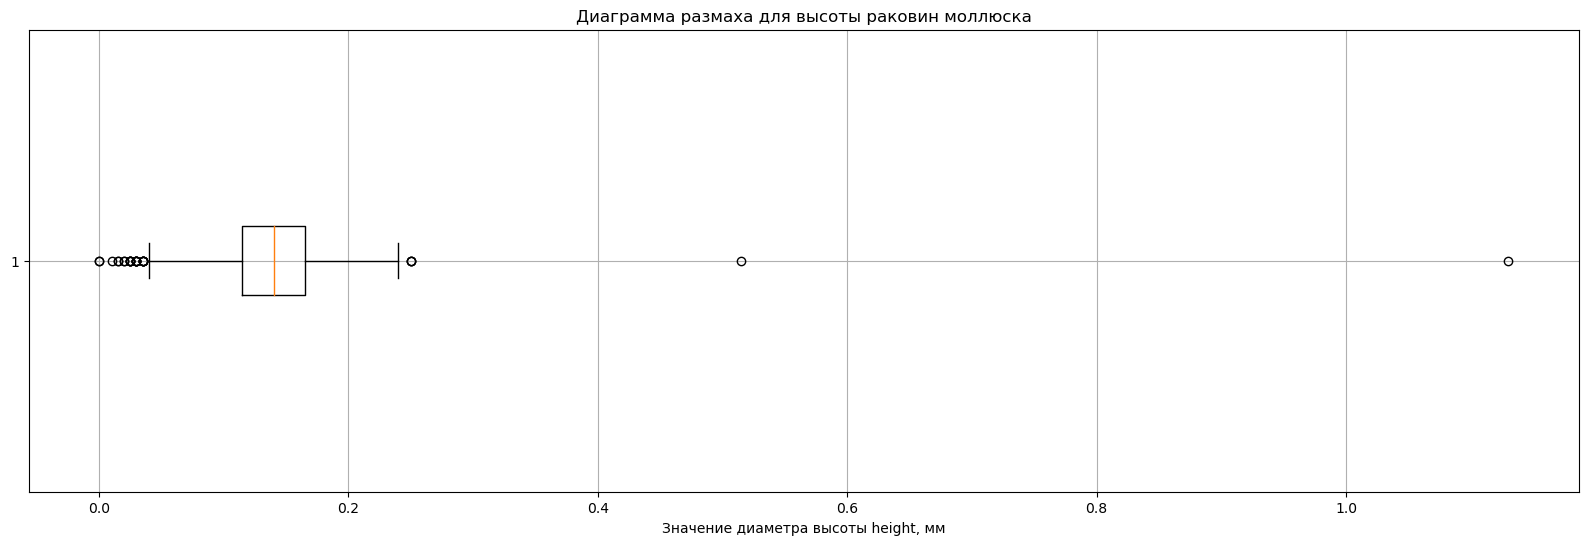

In [21]:
plt.figure(figsize=(20, 6))
plt.boxplot(data['height'], vert=False)
plt.title('Диаграмма размаха для высоты раковин моллюска')
plt.xlabel('Значение диаметра высоты height, мм')
plt.grid(True)
plt.show()

In [22]:
# процент выбросов от общего числа строк в датасете
100 * len(data[(data['height'] <= 0.025) | (data['height'] > 0.24)]) / data.shape[0]

0.41192149260964384

Выводы:
1. распределение более приближено к равномерному, однако существуют экстремальные выбросы. От значений более 0.4 мм имеет смысл избавиться.
2. как видно, общий число выбросов менее десятой доли процента.
3. максимальное распределение высот раковин составляет 0,15 мм.

In [23]:
data_cl = data[data['height'] < 0.4]

#### График плотности распределения массы целого моллюска

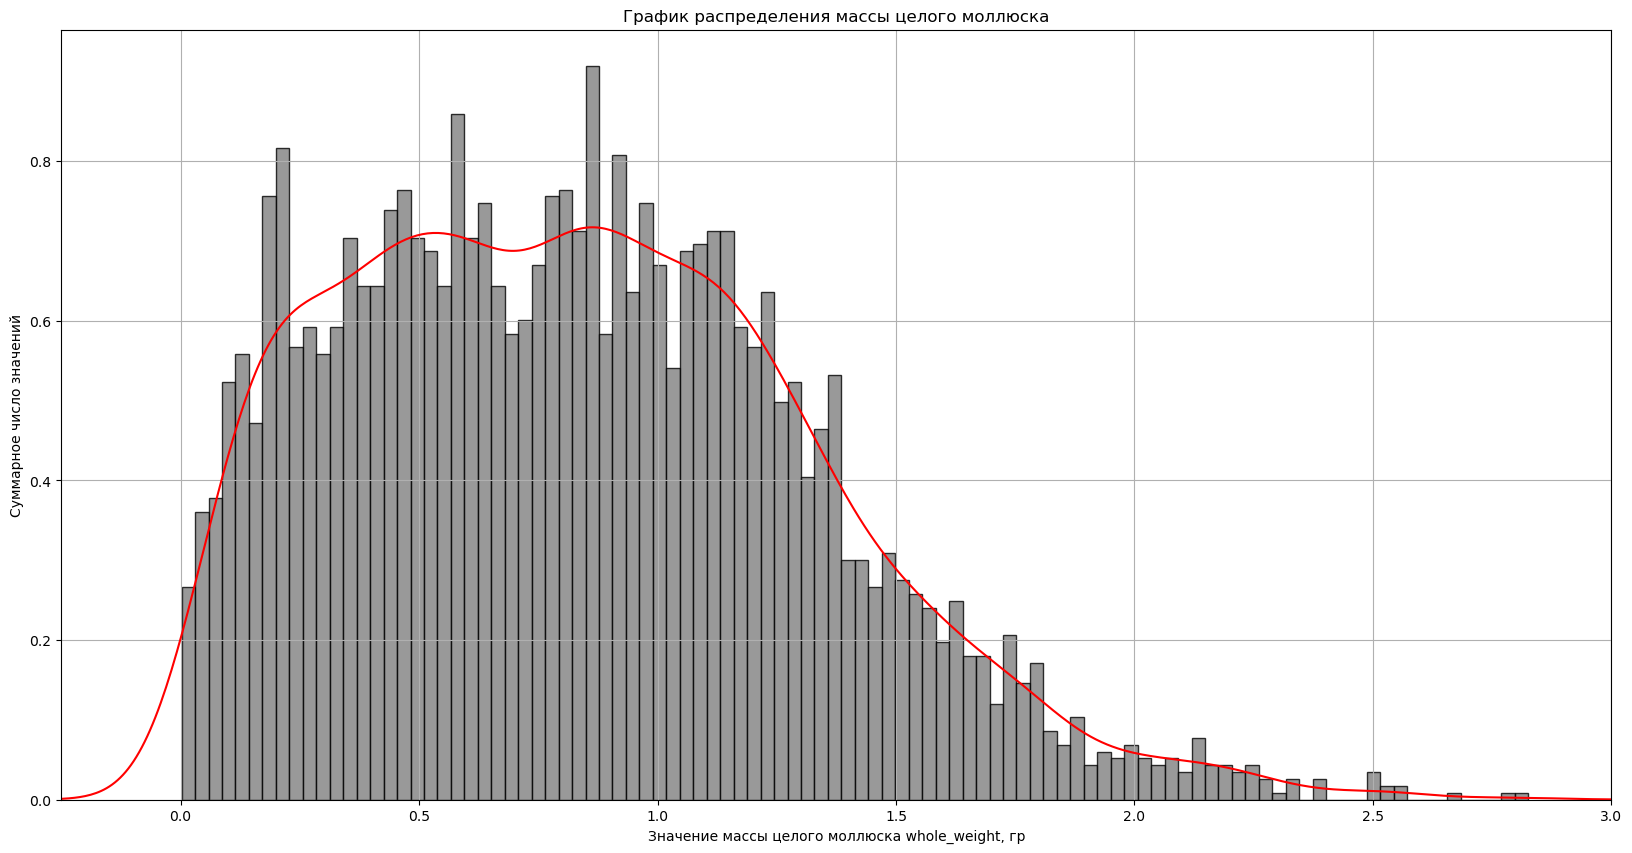

In [24]:
plt.figure(figsize=(20,10))
data_cl['whole_weight'].plot(
    kind='hist', 
    density=True, 
    alpha=0.8, 
    bins=100, 
    color='gray',
    edgecolor='black'
                   )
data_cl['whole_weight'].plot(
    kind='density', 
    color='red'
                   )
plt.title('График распределения массы целого моллюска')
plt.xlim(-0.25, 3)
plt.xlabel('Значение массы целого моллюска whole_weight, гр')
plt.ylabel('Суммарное число значений')
plt.grid(True)
plt.show()

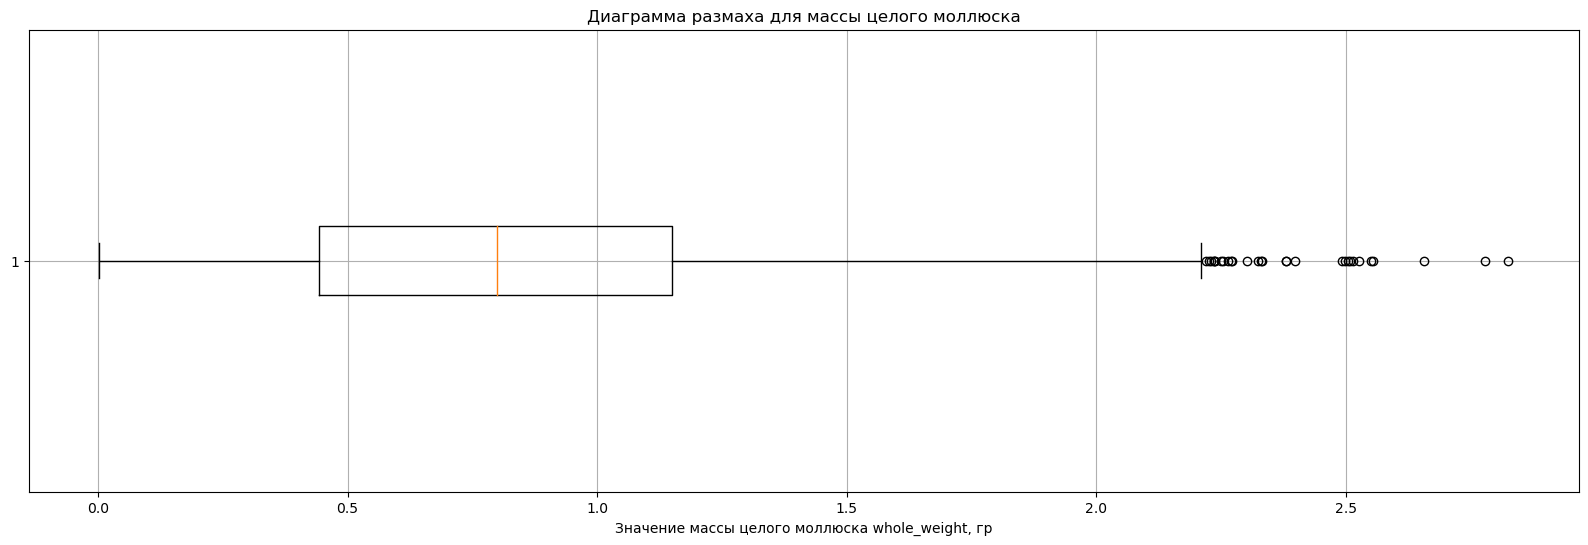

In [25]:
plt.figure(figsize=(20, 6))
plt.boxplot(data_cl['whole_weight'], vert=False)
plt.title('Диаграмма размаха для массы целого моллюска')
plt.xlabel('Значение массы целого моллюска whole_weight, гр')
plt.grid(True)
plt.show()

In [26]:
# Число выбросов на диаграмме размаха для массы целого моллюска
len(data_cl[(data_cl['whole_weight'] > 2.25)])

22

In [27]:
# процент выбросов от общего числа строк в датасете
100 * len(data_cl[(data_cl['whole_weight'] > 2.25)]) / data_cl.shape[0]

0.5333333333333333

Выводы:
1. в основном, целый моллюск весит в диапазоне от половины грамма до 1,2 грамма. 
2. распределение массы целого моллюска достигает плато чуть менее 0.8 грамма, а явного экстремума визуально не наблюдается. Это говорит об однородности раковин.
3. наличие выбросов всего в полпроцента явно не критично. Так что избавимся от таких строк.

In [28]:
data_cl = data_cl[(data_cl['whole_weight'] <= 2.5)]

#### График плотности распределения массы очищенного моллюска
Масса очищенного галиотиса подразумевает только массу мяса

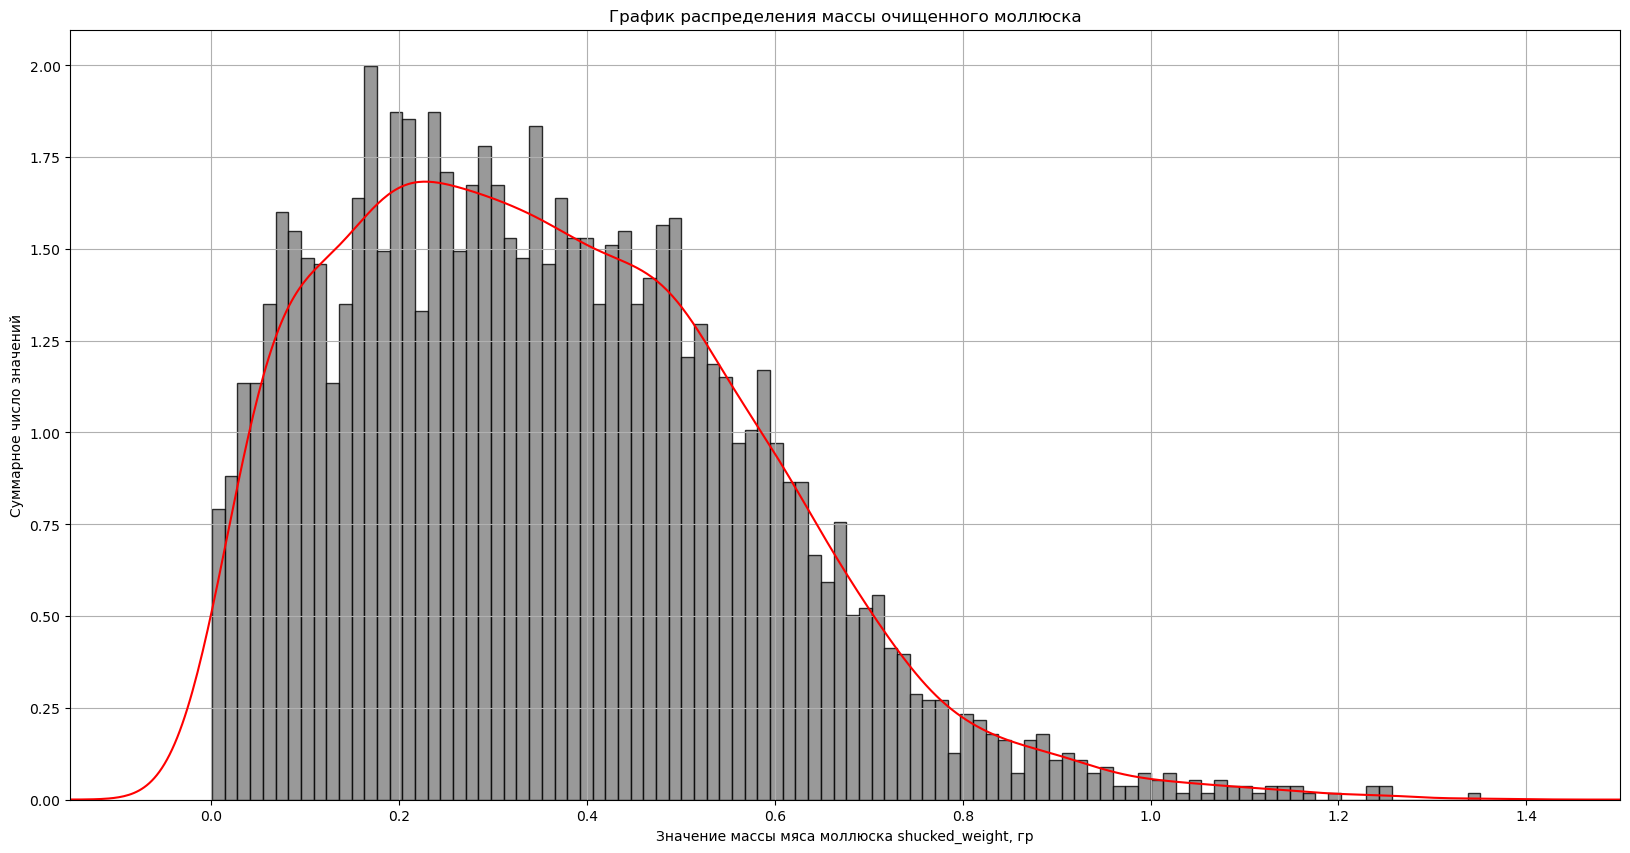

In [29]:
plt.figure(figsize=(20,10))
data_cl['shucked_weight'].plot(
    kind='hist', 
    density=True, 
    alpha=0.8, 
    bins=100, 
    color='gray',
    edgecolor='black'
                   )
data_cl['shucked_weight'].plot(
    kind='density', 
    color='red'
                   )
plt.title('График распределения массы очищенного моллюска')
plt.xlim(-0.15, 1.5)
plt.xlabel('Значение массы мяса моллюска shucked_weight, гр')
plt.ylabel('Суммарное число значений')
plt.grid(True)
plt.show()

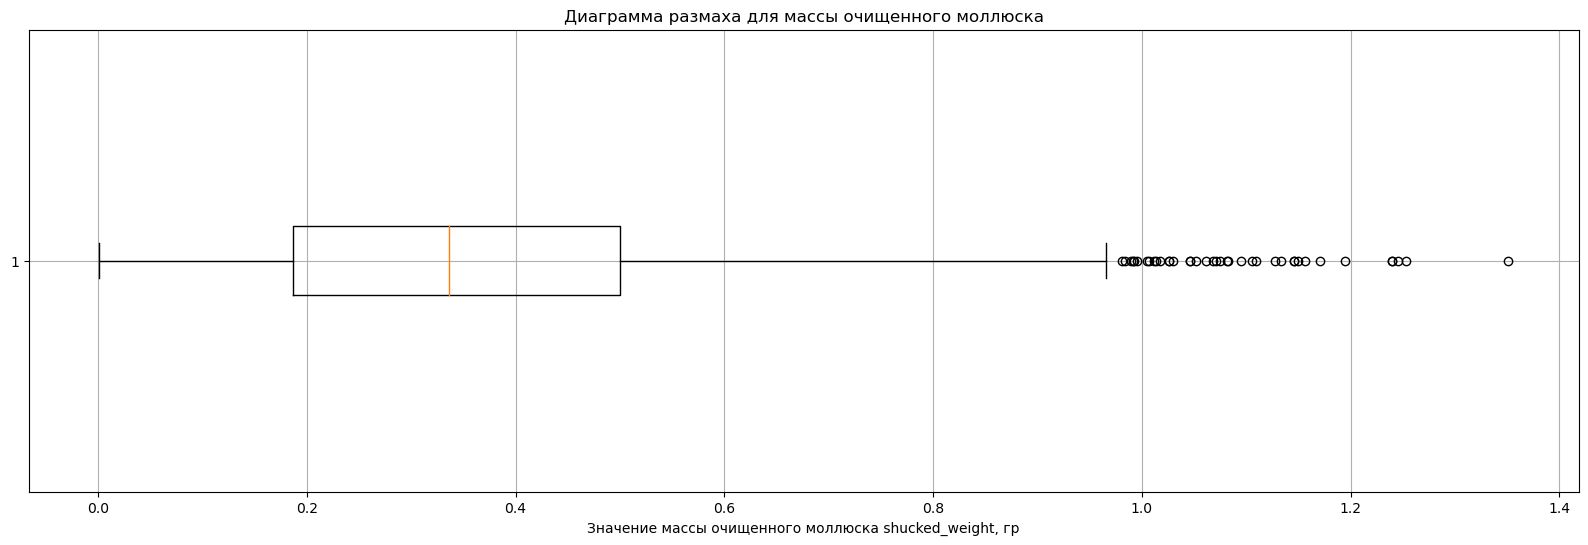

In [30]:
plt.figure(figsize=(20, 6))
plt.boxplot(data_cl['shucked_weight'], vert=False)
plt.title('Диаграмма размаха для массы очищенного моллюска')
plt.xlabel('Значение массы очищенного моллюска shucked_weight, гр')
plt.grid(True)
plt.show()

In [31]:
# процент выбросов от общего числа строк в датасете
100 * len(data_cl[(data_cl['shucked_weight'] > 0.966)]) / data_cl.shape[0]

0.9475218658892128

Выводы:
1. масса очищенного моллюска составляет, в основном, от 0,2 до 0,5 грамм.
2. однако некоторые особи могут достигать массы как в 1 грамм, так и чуть более 0, что характерно для достаточно молодых моллюсков.
3. общее число выбросов, судя по диаграмме размаха составляет менее 1%.

#### График плотности распределения массы потрохов моллюска
Масса потрохов подсчитывается после обескровливания галиотиса

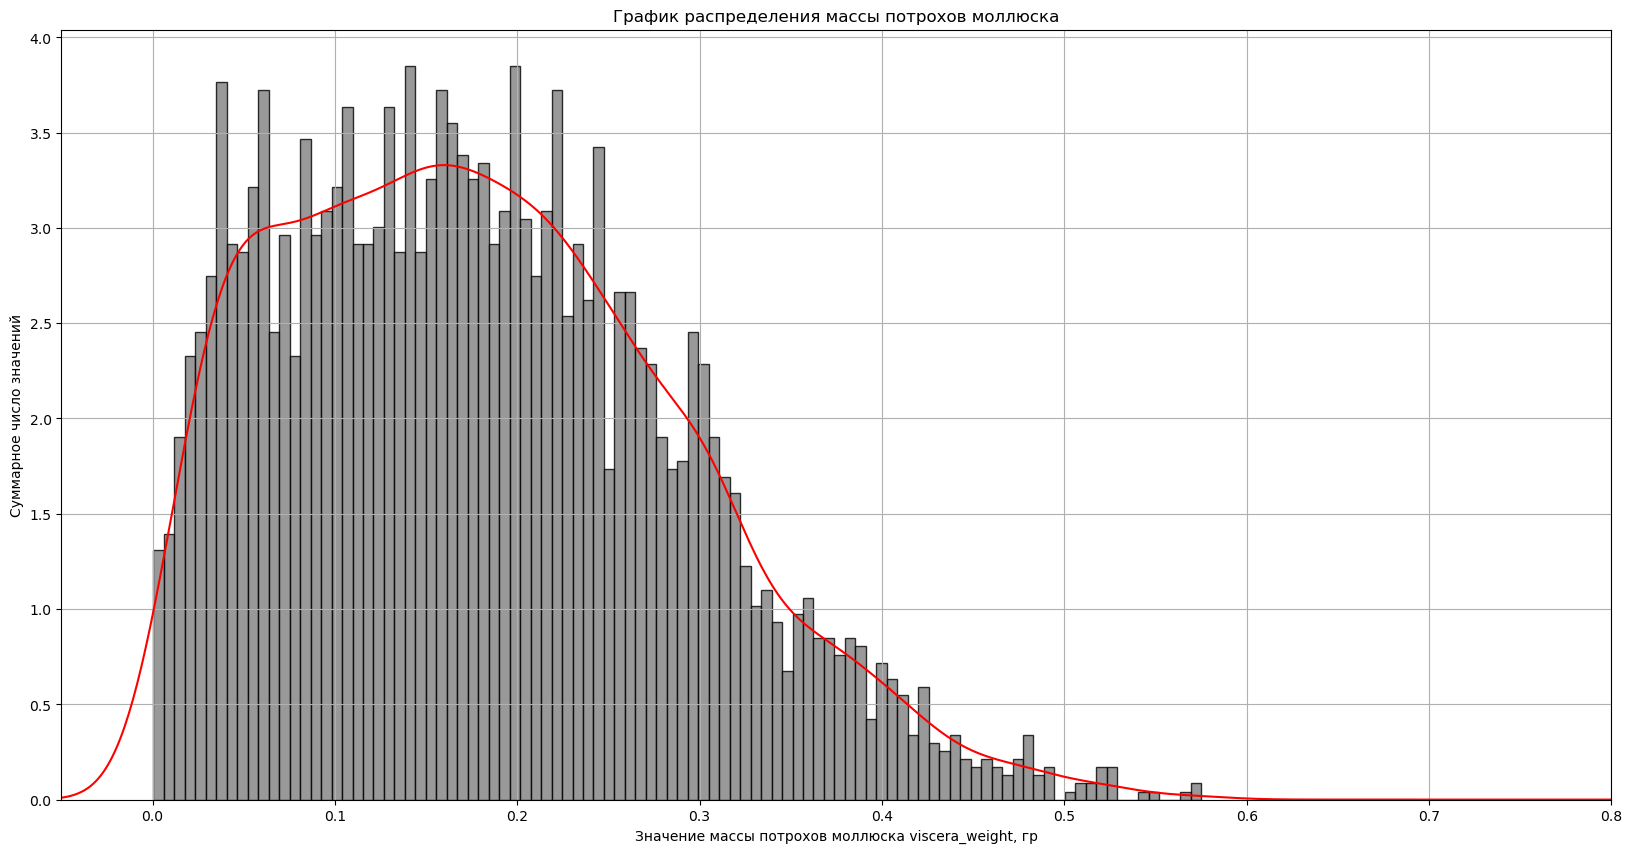

In [32]:
plt.figure(figsize=(20,10))
data_cl['viscera_weight'].plot(
    kind='hist', 
    density=True, 
    alpha=0.8, 
    bins=100, 
    color='gray',
    edgecolor='black'
                   )
data_cl['viscera_weight'].plot(
    kind='density', 
    color='red'
                   )
plt.title('График распределения массы потрохов моллюска')
plt.xlim(-0.05, 0.8)
plt.xlabel('Значение массы потрохов моллюска viscera_weight, гр')
plt.ylabel('Суммарное число значений')
plt.grid(True)
plt.show()

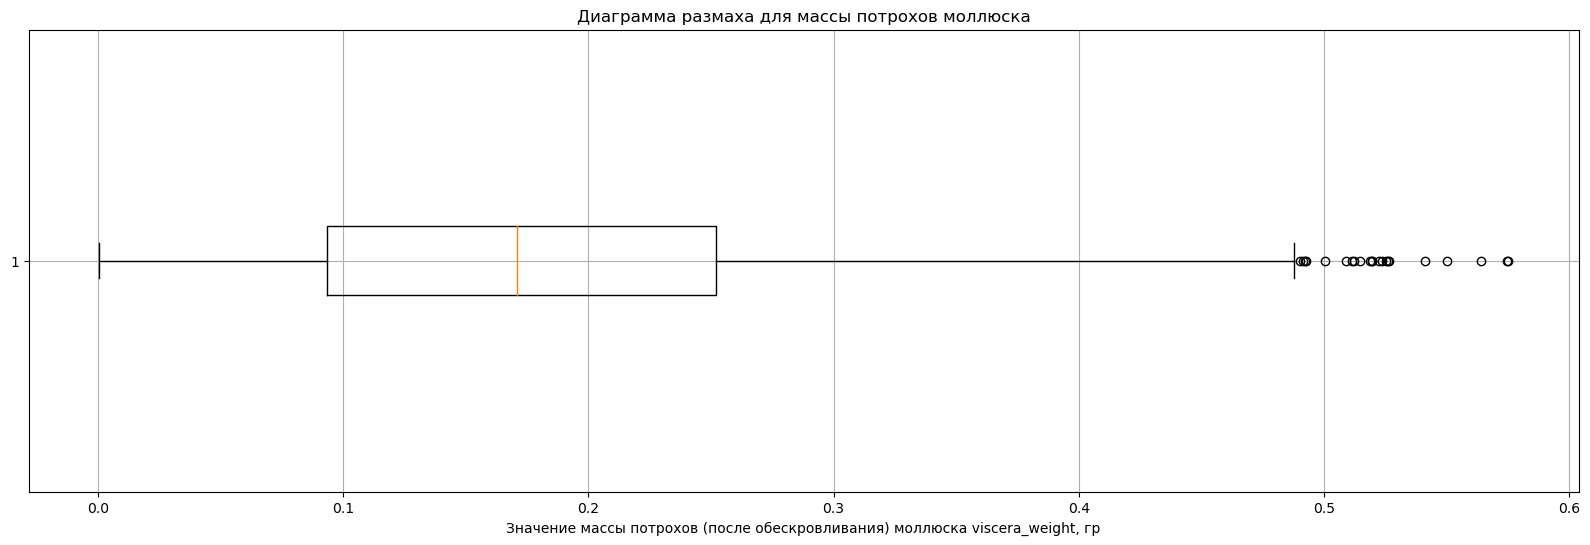

In [33]:
plt.figure(figsize=(20, 6))
plt.boxplot(data_cl['viscera_weight'], vert=False)
plt.title('Диаграмма размаха для массы потрохов моллюска')
plt.xlabel('Значение массы потрохов (после обескровливания) моллюска viscera_weight, гр')
plt.grid(True)
plt.show()

In [34]:
# просмотр кажущихся аномальными значений масс потрохов моллюска
# data[data['viscera_weight'] < 0.01]

In [35]:
# процент выбросов от общего числа строк в датасете
100 * len(data_cl[(data_cl['viscera_weight'] > 0.49)]) / data_cl.shape[0]

0.5102040816326531

Выводы:
1. масса потрохов крайне мала по сравнению с другими массами. Поскольку она подсчитывается после выполнения иссушения (обескровливания) потрохов, имеем распределение, находящееся в границах от чуть выше нуля до 0,5 граммов.
2. при этом визуально достаточно сложно выделить интервал масс, характерный для данного признака, на котором демонстрируются наиболее частые результаты. Указанный выше интервал достаточно спокойно представлен.
3. как и в случае выше, имеем менее процента выбросов.

#### График плотности распределения массы скорлупы моллюска
Подразумевается масса моллюска после высушивания

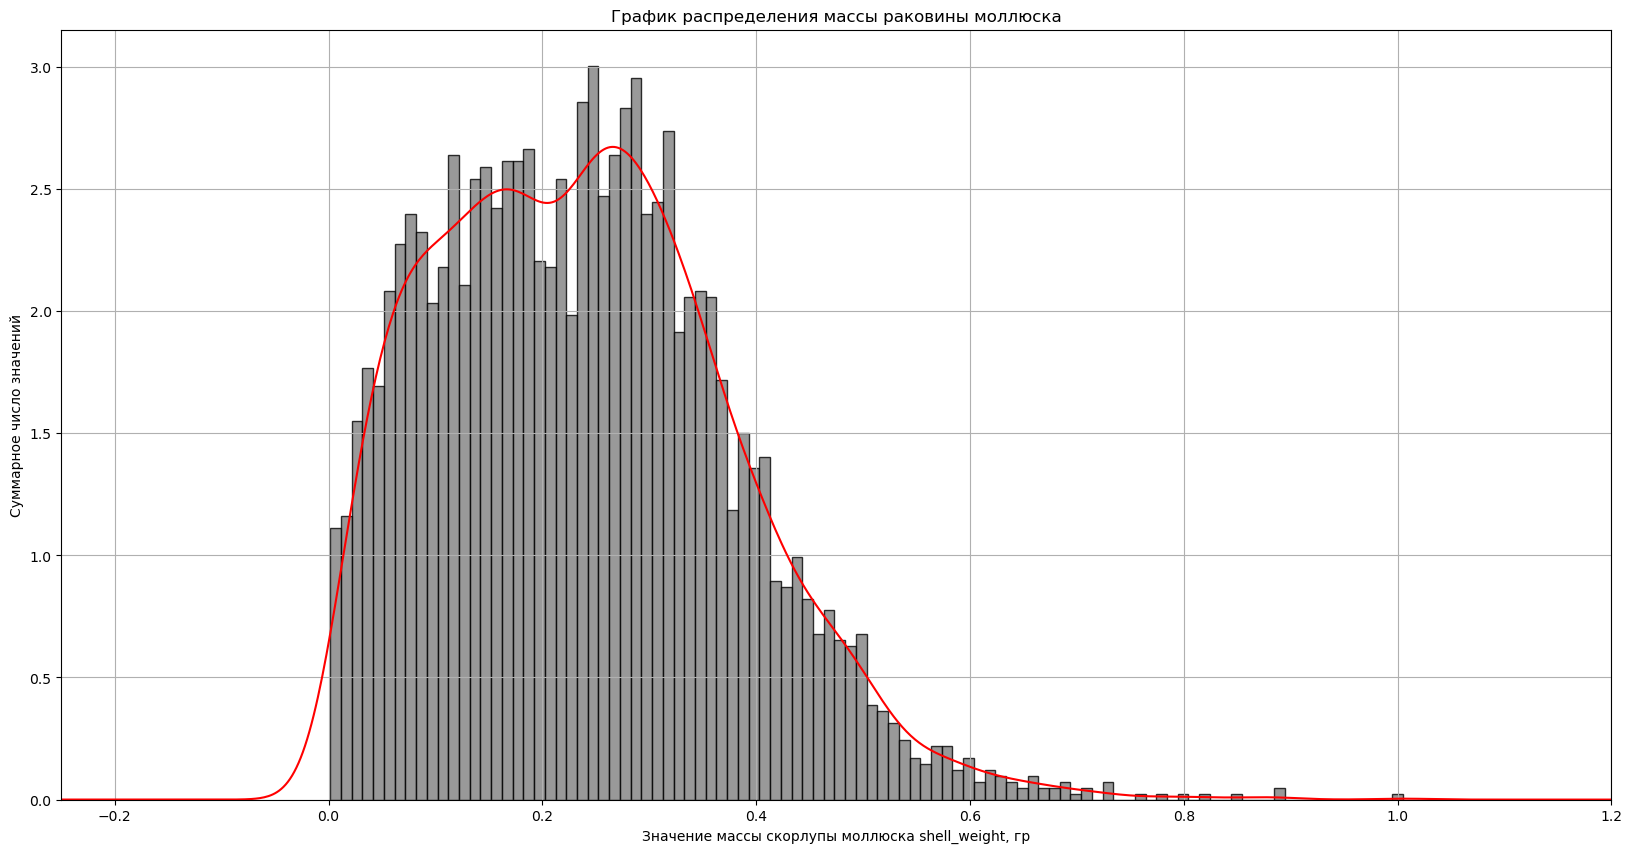

In [36]:
plt.figure(figsize=(20,10))
data_cl['shell_weight'].plot(
    kind='hist', 
    density=True, 
    alpha=0.8, 
    bins=100, 
    color='gray',
    edgecolor='black'
                   )
data_cl['shell_weight'].plot(
    kind='density', 
    color='red'
                   )
plt.title('График распределения массы раковины моллюска')
plt.xlim(-0.25, 1.2)
plt.xlabel('Значение массы скорлупы моллюска shell_weight, гр')
plt.ylabel('Суммарное число значений')
plt.grid(True)
plt.show()

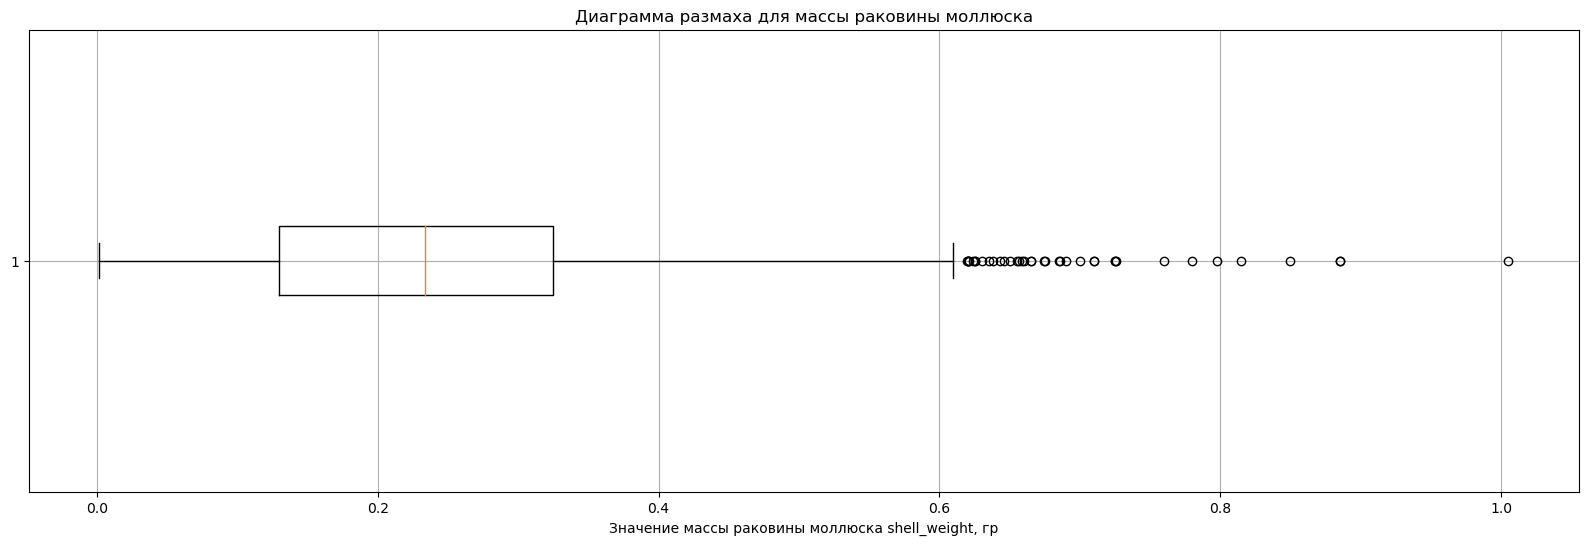

In [37]:
plt.figure(figsize=(20, 6))
plt.boxplot(data_cl['shell_weight'], vert=False)
plt.title('Диаграмма размаха для массы раковины моллюска')
plt.xlabel('Значение массы раковины моллюска shell_weight, гр')
plt.grid(True)
plt.show()

In [38]:
# процент выбросов от общего числа строк в датасете
100 * len(data_cl[(data_cl['shell_weight'] >= 0.625)]) / data_cl.shape[0]

0.8017492711370262

Выводы:
1. масса раковин распределяется в границах от чуть более 0 до 0,6 граммов. БОльшие значения не характерны для галиолисов.
2. наиболее часты раковины массой от 0,1 до 0,3 грамма. Выделить какие-либо экстремальные значения в данном случае не получается.
3. в данном случае число выбросов составляет менее половины десятой доли процента. И от таких выбросов можно смело избавиться, ввиду их малочисленности. 

In [39]:
#data = data[(data['viscera_weight'] < 0.625)]

#### График плотности распределения колец раковин
Каждое кольцо приблизительно указывает на возраст галиотиса. Отношение: 1 кольцо соответствует приблизительно 1,5 года. Для дальнейших расчётов оперировать возрастом в годах нет необходимости, поэтому оставим подсчёт в кольцах.

In [40]:
# общее число различных колец
len_rings = len(data_cl['rings'].unique())
len_rings

28

На основании полученного результата указываем число корзин на графике плотности распределения. В отличие от иных графиков, здесь нет смысла указывать число более 29 (де-факто колец и того меньше).

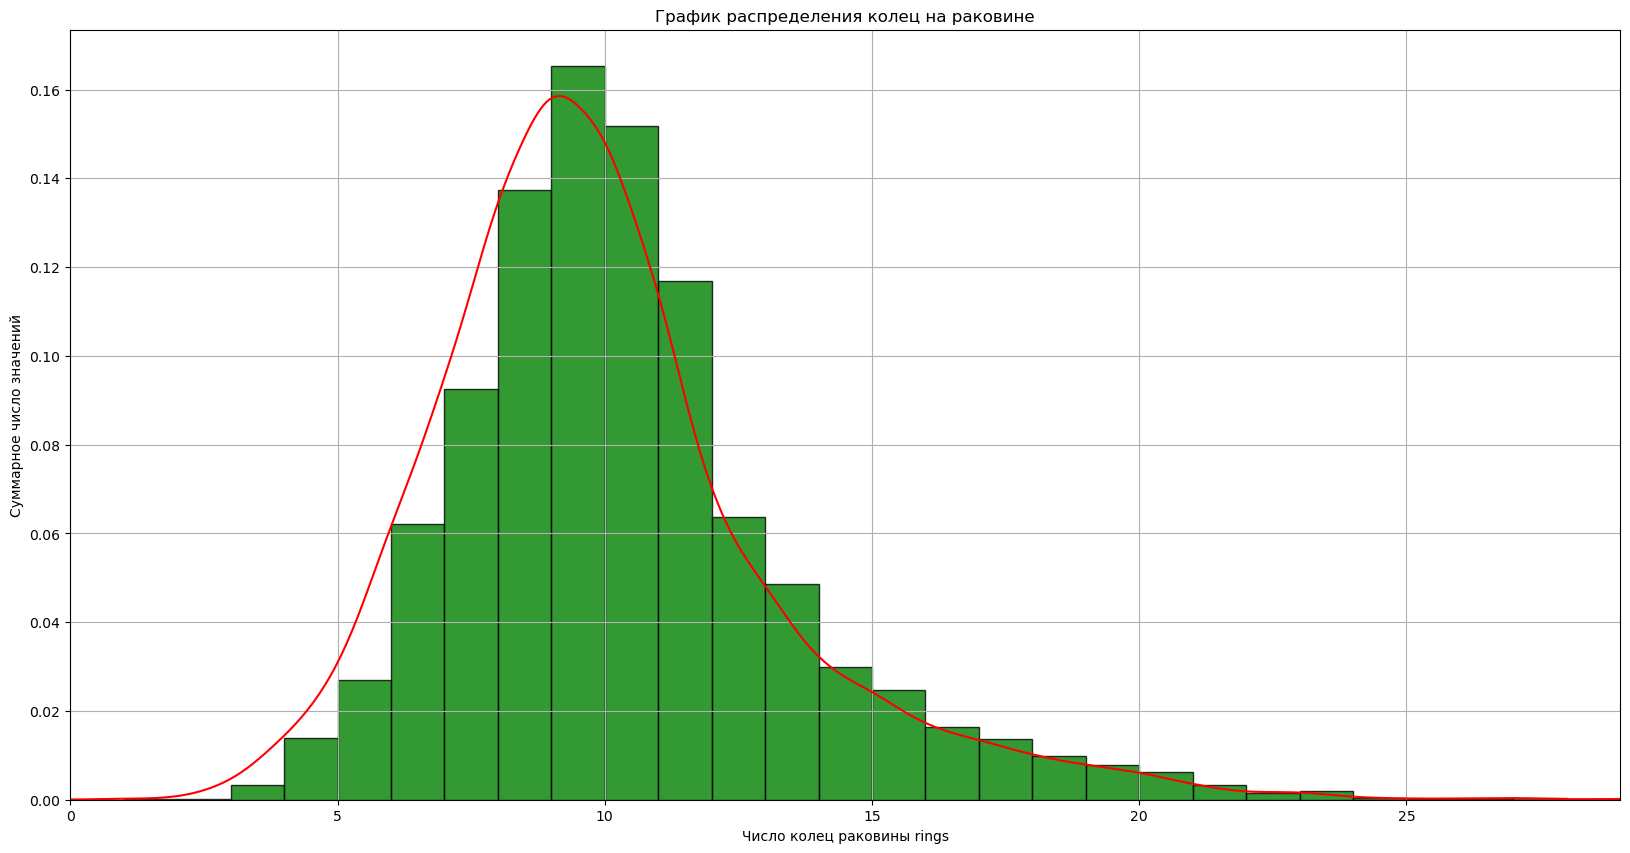

In [41]:
plt.figure(figsize=(20,10))
data_cl['rings'].plot(
    kind='hist', 
    density=True, 
    alpha=0.8, 
    bins=len_rings, 
    color='green',
    edgecolor='black'
                   )
data_cl['rings'].plot(
    kind='density', 
    color='red'
                   )
plt.title('График распределения колец на раковине')
plt.xlim(0, 29)
plt.xlabel('Число колец раковины rings')
plt.ylabel('Суммарное число значений')
plt.grid(True)
plt.show()

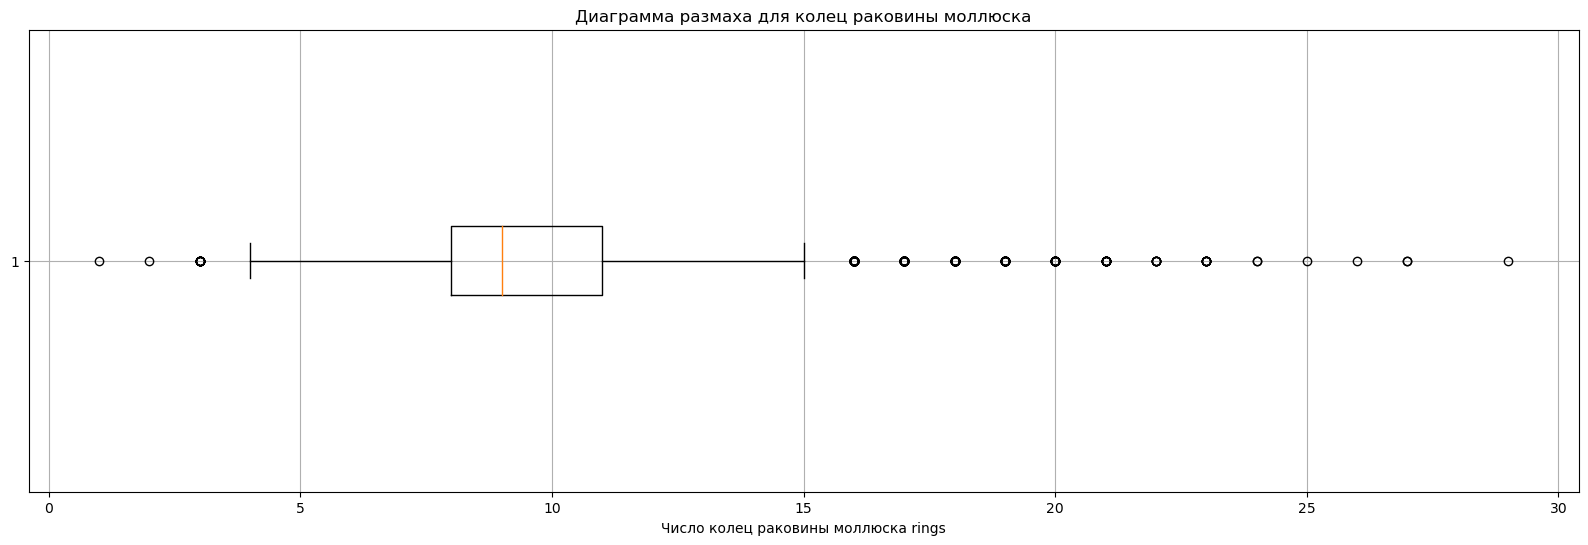

In [42]:
plt.figure(figsize=(20, 6))
plt.boxplot(data_cl['rings'], vert=False)
plt.title('Диаграмма размаха для колец раковины моллюска')
plt.xlabel('Число колец раковины моллюска rings')
plt.grid(True)
plt.show()

In [43]:
# процент выбросов от общего числа строк в датасете
100 * len(data_cl[(data_cl['rings'] > 15) | (data_cl['rings'] < 4)]) / data_cl.shape[0]

6.63265306122449

Выводы:
1. распределение колец в выборке можно считать нормальным, ввиду явного возрастания и затухания графика плотности при достижении значения в 10 колец. От 8 до 11 колец наиболее часто встречаются в выборке.
2. это говорит о наличии в датасете моллюсков галиолисов в возрасте от 12 до 17 лет, которые наиболее часто встречаются среди прочих. Общий же диапазон возрастов, если судить по кольцам на раковине, составляет от 6 до 21,5 года. 
3. согласно диаграмме размаха выбросами в данном случае считаются все значения менее 4 и более 15 колец. Однако суммарно это составляет более 6% от общего числа значений очищенного датасета, ввиду чего избавляться от подобных данных не станем. 

## Анализ целевой переменной

In [44]:
print(f'По результату очистки данных в ходе ИАД датасет составляет {round(100 * data_cl.shape[0] / data.shape[0], 2)}% от первоначального')
print(f'Число строк в датасете {data_cl.shape[0]}, число признаков {data_cl.shape[1]}')

По результату очистки данных в ходе ИАД датасет составляет 99.73% от первоначального
Число строк в датасете 4116, число признаков 9


Как видно, в датасете находится немногим более 4000 объектов и 9 признаков (хотя это итак указано в условиях), из которых один является целевым, а именно `rings`. Собственно говоря, число колец раковины галиолиса является единственным признаком с целочисленным типом данных. 

Для датасета выполним проверку сбалансированности таргетов для целевого признака.

In [45]:
data_cl['rings'].value_counts()

9     680
10    625
8     565
11    481
7     381
12    262
6     256
13    200
14    123
5     111
15    102
16     67
4      57
17     56
18     41
19     32
20     26
21     14
3      14
23      8
22      6
27      2
24      2
1       1
26      1
29      1
2       1
25      1
Name: rings, dtype: int64

Ввиду того, что значения не распределены примерно поровну (выявили ранее), то можно считать, что значения целевого признака не сбалансированы. Это может привести к проблемам при обучении модели в дальнейшем. Чтобы частично избавиться от подобных проблем, необходимо избавиться от явных выбивающихся значений, которые выше продемонстрированы на диаграмме размаха, т.е. избавимся от колец более 23. 

Также возможно выполнить проверку на мультиколлинеарность для исходного датасета. В результат получим матрицу корреляций между всеми столбцами (признаками) датасета. Если есть сильная корреляция между какими-то столбцами, то это может указывать на мультиколлинеарность. В таком случае можно рассмотреть возможность удаления одного из коррелирующих столбцов.

In [46]:
data_cl = data_cl[data_cl['rings'] <= 23]

## Построение матриц корреляций
### Матрицы корреляции для количественных признаков

Ввиду необходимости исследовать поведения целевого признака, который распределяется нормально (очень похоже на распределение Гаусса), имеет смысл применить **корреляцию Пирсона**. Построим половину матрицы, поскольку этого достаточно для выявления взаимосвязей между признаками. Также необходимо учесть, что в данной матрице не будет отображаться пол моллюска, поскольку это категориальный признак.

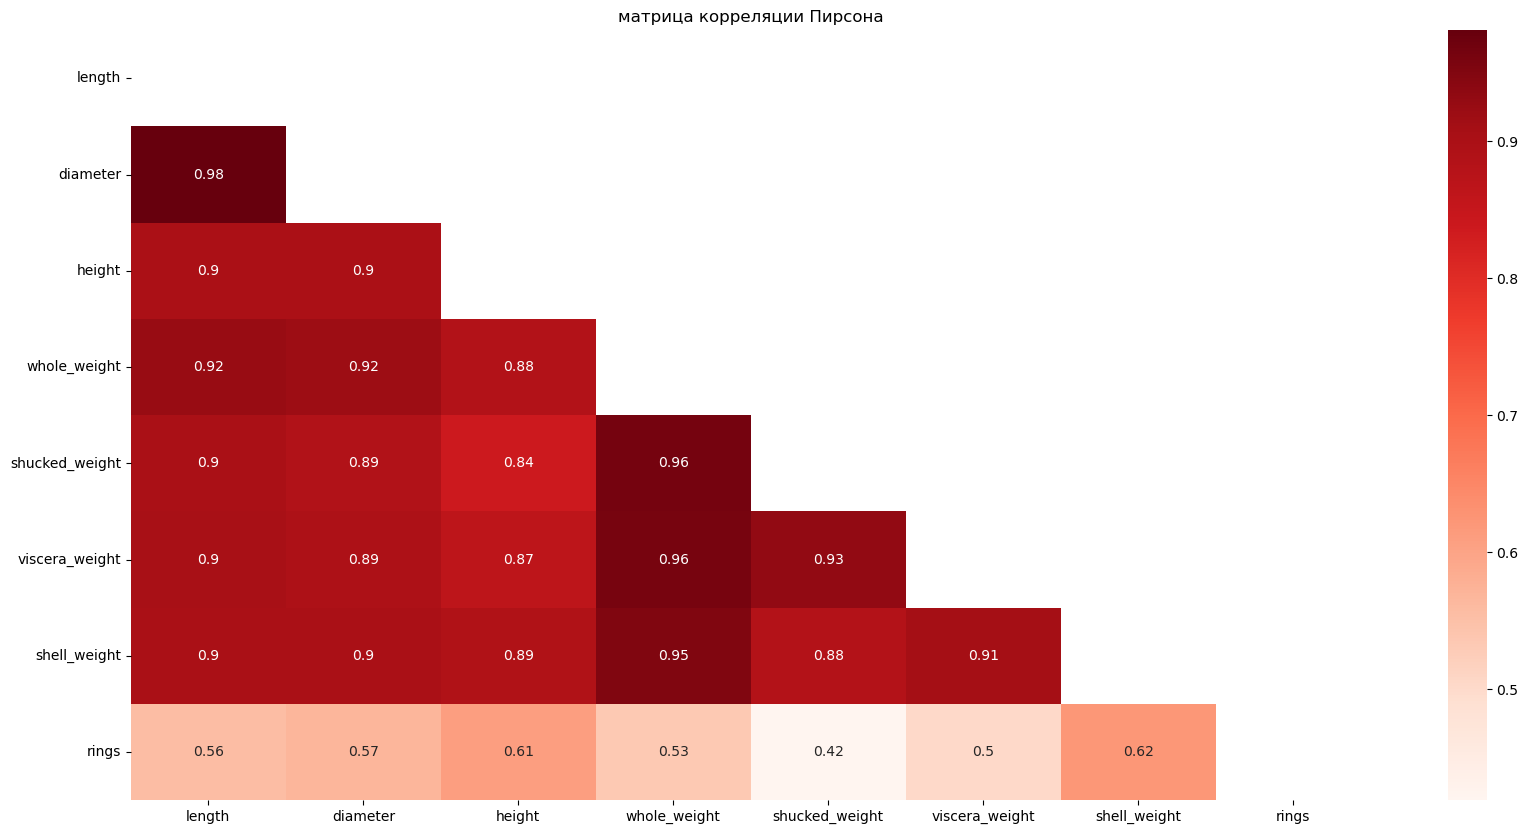

In [47]:
corr = data_cl.corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
plt.figure(figsize=(20,10))
sns.heatmap(corr, mask=mask, cmap="Reds", annot=True)
plt.title('матрица корреляции Пирсона')
plt.show()

Если принять факт, что сильная корреляция считается от **0.7**, то целевой (он же таргетированный) признак `rings` сильно нигде не коррелирует с другими признаками. Однако и тут заметно, что наиболее слабая корреляции наблюдается в случае массы очищенного моллюска *Shucked weight*. Довольно сложно интерпретировать данные показатели, поскольку разница в числах незначительная, но при желании можно представить следующее: рост возраста моллюска сказывается слабее на содержание мяса в нём, чем на содержание раковины галиолиса (признак *Shell weight*). Тем самым можно предположить, что при росте галиолиса внутренности (мясо) приращается менее быстро, нежели скорлупа. Возможно это связано с физиологией данного беспозвоночного, который тратит свою жизненную энергию на кальций, использующийся на строительство клеток раковин.

Теперь оценим более детально корреляции между количественными непрерывными признаками, а для этого оптимальнее использовать корреляцию Спирмена.

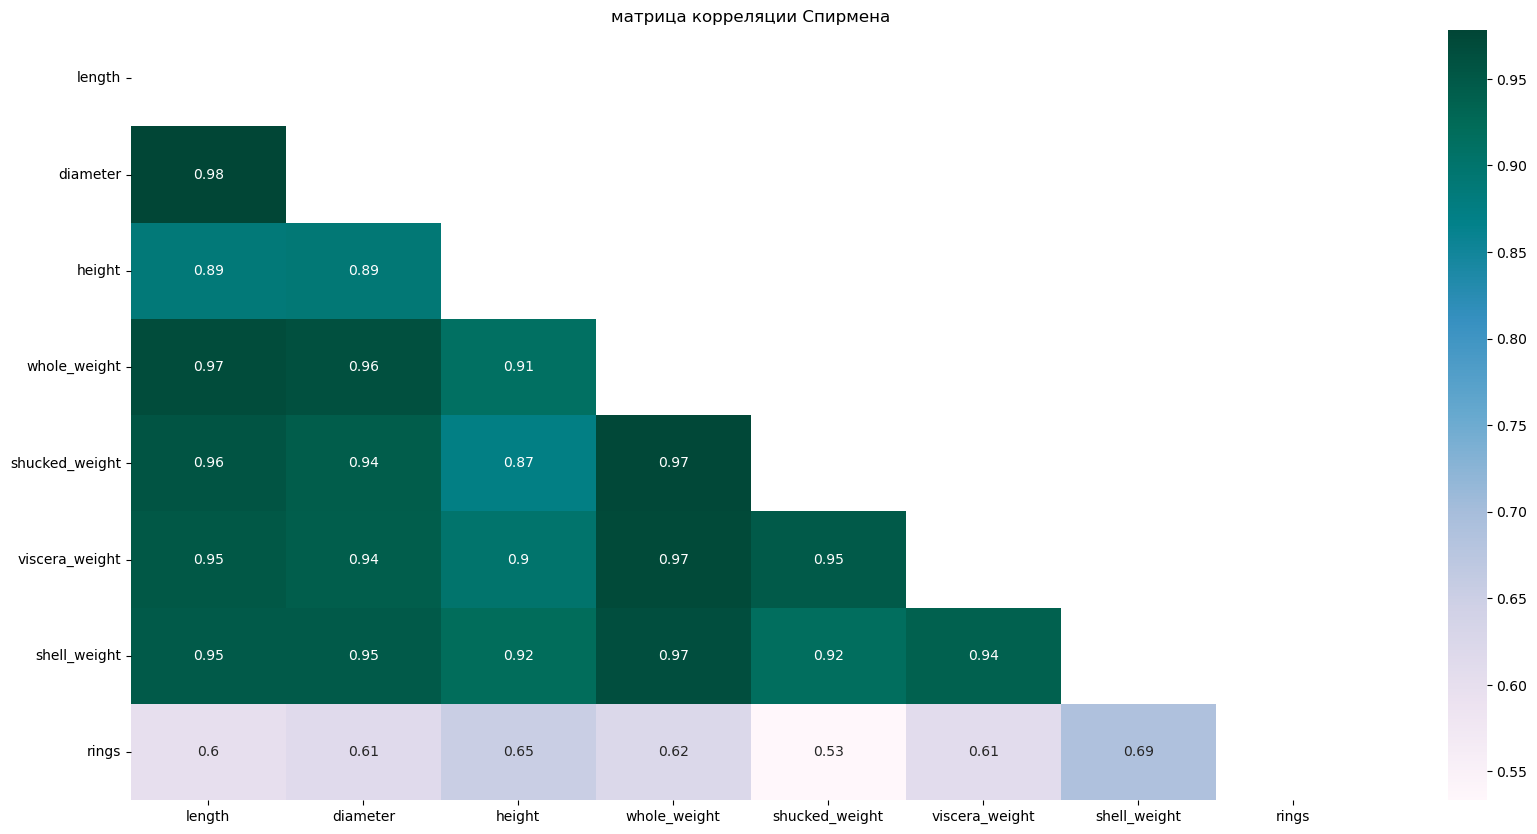

In [48]:
corr = data_cl.corr(method='spearman')
mask = np.triu(np.ones_like(corr, dtype=bool))
plt.figure(figsize=(20,10))
sns.heatmap(corr, mask=mask, cmap="PuBuGn", annot=True)
plt.title('матрица корреляции Спирмена')
plt.show()

По представленным результатам матрицы **корреляций Спирмена** наблюдаем очень сильные зависимости (более **0.9**) между практически всеми количественными признаками. Это означает, что при росте моллюска растут все признаки, по которым оценивается галиолис. И масса, и размеры. 

Также очень важно отметить тот факт, что присутствующая линейная зависимость в количественных значениях может в ходе последующего машинного обучения сказаться. И если бы у нас стояла задача выбрать и обучить предсказательную модель, то вполне могла всплыть проблемы мультиколлинеарности, о которой сказано выше. 

### Тест $X^2$
Для выполнения теста $X^2$ необходимо иметь два категориальных признака. В данном датасете только признак `sex` является категориальным. Поэтому тест выполнить нельзя. Однако, если подобная задача стоит особняком, то можно представить следующую картину, при которой признак `rings` также является категориальным, поскольку отчасти связан с категориями (кольца), по которым можно судить о возрасте моллюска. Для такого допущения и выполним подсчёт.

Согласно классификации в [статье на хабре](https://habr.com/ru/companies/mygames/articles/677074/) выполним $X^2$-тест на независимость для указанных выше признаков.

In [49]:
# создаем таблицу сопряженности для категориальных признаков
contingency_table = pd.crosstab(data_cl['sex'], data_cl['rings'])

chi2, p_value, dof, expected = chi2_contingency(contingency_table)
print(f'статистика теста   {chi2}\n\np-значение   {p_value}\n\nчисло степеней свободы   {dof}')
print()
print(f'ожидаемые частоты {expected}')

статистика теста   1207.3384045990695

p-значение   3.4165064051226434e-224

число степеней свободы   44

ожидаемые частоты [[  0.34801655   0.34801655   4.87223169  19.8369433   38.62983694
   89.09223655 132.59430518 196.62935021 236.65125335 217.51034315
  167.39596009  91.18033585  69.60330981  42.80603553  35.497688
   23.31710879  19.48892675  14.26867851  11.13652957   9.04843028
    4.87223169   2.08809929   2.78413239]
 [  0.30518374   0.30518374   4.2725724   17.39547335  33.87539547
   78.12703821 116.27500608 172.4288148  207.52494524 190.73983938
  146.79338038  79.95814067  61.0367486   37.53760039  31.12874179
   20.44731078  17.09028961  12.51253346   9.76587978   7.93477732
    4.2725724    1.83110246   2.44146994]
 [  0.34679971   0.34679971   4.85519591  19.76758335  38.49476758
   88.78072524 132.13068873 195.941835   235.82380141 216.74981747
  166.81065953  90.86152349  69.35994159  42.65636408  35.37357021
   23.23558043  19.42078365  14.21878803  11.09759065   9

Интерпретировать полученные результаты можно следующим образом:
- значение статистики теста (**1158.37**) говорит о том, что есть сильная зависимость между полом и числом колец
- _p-value_ (**7.69e-217**) очень мало, следовательно нулевая гипотеза (отсутствие связи между признаками) отвергается на любом уровне значимости
- число степеней свободы **40** говорит о количестве независимых переменных, которые были использованы для расчета статистики теста; в данном случае, чем больше степеней свободы, тем меньше вероятность получить такое же значение статистики случайно при отсутствии связи между признаками
- ожидаемые частоты показывают, какое количество наблюдений ожидалось бы в каждой ячейке таблицы сопряженности, если бы признаки были независимыми.

### ANOVA
Для проверки связи между непрерывными признаками и целевым признаком используем `ANOVA`. Поскольку в датасете кроме признака пола все остальные признаки являются числовыми, в т.ч. целевой, то сделаем два расчёта. Тем самым подтвердим или опровергнем зависимость от значений признака `sex` для числовых признаков.

In [50]:
grouped_data = data_cl.groupby('sex')['rings'].apply(list)
f_statistic, p_value = stats.f_oneway(*grouped_data)

print(f'F-статистика {f_statistic}\np-value {p_value}')
print('\nВывод:')
if p_value >= 0.05:
    print('Нулевая гипотеза (о равенстве средних значений) верна')
else:
    print('Нулевая гипотеза (о равенстве средних значений) отвергается')

F-статистика 461.4946969780273
p-value 1.6187381631445337e-181

Вывод:
Нулевая гипотеза (о равенстве средних значений) отвергается


In [51]:
grouped_data = data_cl.groupby('sex')['diameter'].apply(list)
f_statistic, p_value = stats.f_oneway(*grouped_data)

print(f'F-статистика {f_statistic}\np-value {p_value}')
print('\nВывод:')
if p_value >= 0.05:
    print('Нулевая гипотеза (о равенстве средних значений) верна')
else:
    print('Нулевая гипотеза (о равенстве средних значений) отвергается')

F-статистика 858.711487428459
p-value 2.74139312282e-312

Вывод:
Нулевая гипотеза (о равенстве средних значений) отвергается


Полученное значение `f_statistic` показывает, насколько отличаются средние значения количества колец в разных группах. Значение `p-value` говорит о вероятности получить такое или еще более экстремальное значение `f_statistic` случайно при условии, что нулевая гипотеза (о равенстве средних значений) верна. Однако значение `p-value` на порядки меньше заданного уровня значимости **0.05**, ввиду чего нулевая гипотеза отвергается. Можно сделать вывод об отличии средних значений в группах.

Общий вывод таков, средние значения как числа колец, так и диаметра ракушки различаются в зависимости от одного из трёх значений признака `sex`. Поскольку различаются значения *M* (мужская особь), *F* (женская особь) и *I* (infant, т.е. молодая особь), то ожидания различий в размерах и числе колец оказались подтверждёнными.

In [52]:
# сохраняем датасет для дальнейшего использования в Pipeline
data_cl.to_csv('abalone_cl.csv', index=False)

## Сравнение библиотек Pandas и Polars
Выполним сравнение быстродействия библиотек `Pandas` и `Polars` касательно ряда случаев. Для этого из датасета `data` масштабированием до миллиона строк создадим новый датасет, на примере которого и проведём исследование.

In [53]:
# версия библиотеки polars
print(pl.__version__)

0.19.19


In [54]:
data_perfomance = data.copy()

while data_perfomance.shape[0] < 1000000:
  data_perfomance = pd.concat([data_perfomance, data])

data_perfomance = data_perfomance[:1000000]
data_perfomance.to_csv("abalone_perfomance.csv", index=False)

print(f'Число строк в увеличенном датасете {data_perfomance.shape[0]}\nЧисло строк в очищенном первоначальном датасете {data.shape[0]}')

Число строк в увеличенном датасете 1000000
Число строк в очищенном первоначальном датасете 4127


### Сравнение загрузки данных
Для начала выполним сравнение времени загрузки для датасета, расположенного локально

In [55]:
%%time
data_pl_l = pl.read_csv("abalone_perfomance.csv")

CPU times: user 674 ms, sys: 111 ms, total: 785 ms
Wall time: 134 ms


In [56]:
%%time
data_pd_l = pd.read_csv("abalone_perfomance.csv")

CPU times: user 480 ms, sys: 116 ms, total: 596 ms
Wall time: 596 ms


Теперь выполним сравнение для датасета `abalone_perfomance.csv`, расположенного в облаке

In [57]:
%%time
url = "https://drive.google.com/uc?id=18q6cp4pnv8M3Wu2-zhuyNTwi3xjdY2PD"
data_pl_n = pl.read_csv(url)

CPU times: user 1.08 s, sys: 277 ms, total: 1.36 s
Wall time: 10.9 s


In [58]:
%%time
data_pd_n = pd.read_csv(url)

CPU times: user 812 ms, sys: 319 ms, total: 1.13 s
Wall time: 6.05 s


Загрузка датасета наиболее быстро происходит в случае библиотеки `polars` в обоих случаях, но при загрузке с локального диска выигрыш во времени 4-5 раз по сравнению с загрузкой через библиотеку `pandas`. А при импорте с сетевого хранилища файла объёмом около 40 Мб выигрыш минимальный, но у библиотеки `pandas`.

### Сравнение фильтрации данных
Для сравнения скорости быстродействия при выполнении фильтрации данных из датасета размером в 1М строк выполним по 3 сценария.

In [59]:
len(data_pd_l[(data_pd_l['height'] > 0.14) & (data_pd_l['sex'] == 'F')])

236469

In [60]:
%%time
data_pl_l.filter((pl.col('height') > 0.14) & (pl.col('sex') == 'F'))

CPU times: user 54.6 ms, sys: 8.99 ms, total: 63.6 ms
Wall time: 36.9 ms


sex,length,diameter,height,whole_weight,shucked_weight,viscera_weight,shell_weight,rings
str,f64,f64,f64,f64,f64,f64,f64,i64
"""F""",0.53,0.415,0.15,0.7775,0.237,0.1415,0.33,20
"""F""",0.55,0.44,0.15,0.8945,0.3145,0.151,0.32,19
"""F""",0.535,0.405,0.145,0.6845,0.2725,0.171,0.205,10
"""F""",0.565,0.44,0.155,0.9395,0.4275,0.214,0.27,12
"""F""",0.615,0.48,0.165,1.1615,0.513,0.301,0.305,10
"""F""",0.58,0.45,0.185,0.9955,0.3945,0.272,0.285,11
"""F""",0.68,0.56,0.165,1.639,0.6055,0.2805,0.46,15
"""F""",0.665,0.525,0.165,1.338,0.5515,0.3575,0.35,18
"""F""",0.68,0.55,0.175,1.798,0.815,0.3925,0.455,19


In [61]:
%%time
data_pd_l[(data_pd_l['height'] > 0.14) & (data_pd_l['sex'] == 'F')]

CPU times: user 91.3 ms, sys: 1.04 ms, total: 92.3 ms
Wall time: 89.5 ms


,sex,length,diameter,height,whole_weight,shucked_weight,viscera_weight,shell_weight,rings
6,F,0.530,0.415,0.150,0.7775,0.2370,0.1415,0.3300,20
9,F,0.550,0.440,0.150,0.8945,0.3145,0.1510,0.3200,19
13,F,0.535,0.405,0.145,0.6845,0.2725,0.1710,0.2050,10
22,F,0.565,0.440,0.155,0.9395,0.4275,0.2140,0.2700,12
24,F,0.615,0.480,0.165,1.1615,0.5130,0.3010,0.3050,10
...,...,...,...,...,...,...,...,...,...
999923,F,0.730,0.575,0.185,1.8795,0.9310,0.3800,0.4825,12
999925,F,0.745,0.565,0.215,1.9310,0.8960,0.4585,0.5000,11
999926,F,0.750,0.570,0.210,2.2360,1.1090,0.5195,0.5450,11
999927,F,0.755,0.625,0.210,2.5050,1.1965,0.5130,0.6785,11


In [62]:
%%time
data_pl_l[['length', 'rings']]

CPU times: user 56 µs, sys: 22 µs, total: 78 µs
Wall time: 82.7 µs


length,rings
f64,i64
0.455,15
0.35,7
0.53,9
0.44,10
0.33,7
0.425,8
0.53,20
0.545,16
0.475,9


In [63]:
%%time
data_pd_l[['length', 'rings']]

CPU times: user 17.8 ms, sys: 15.1 ms, total: 32.9 ms
Wall time: 39.6 ms


,length,rings
0,0.455,15
1,0.350,7
2,0.530,9
3,0.440,10
4,0.330,7
...,...,...
999995,0.480,8
999996,0.480,8
999997,0.495,8
999998,0.495,7


Результат фильтрации данных даёт двоякий результат. При фильтрации по двум условиям быстрее в несколько (примерно 4-6) раз показывает себя библиотека `polars`. А вот при выводе без детальной фильтрации просто двух столбцов `pandas` медлительнее на 3 порядка. Это крайне показательно.

### Сравнение агрегации данных

In [64]:
%%time
data_pl_l.group_by('rings').agg([pl.mean('diameter'), pl.median('whole_weight')]).head()

CPU times: user 94.3 ms, sys: 5.7 ms, total: 100 ms
Wall time: 35.4 ms


rings,diameter,whole_weight
i64,f64,f64
27,0.5,1.698
18,0.464162,1.156
9,0.425707,0.8445
24,0.54,1.79875
3,0.143591,0.0215


In [65]:
%%time
data_pd_l.groupby('rings').agg({'diameter' : 'mean', 'whole_weight' : 'median'}).head()

CPU times: user 64.8 ms, sys: 22.7 ms, total: 87.5 ms
Wall time: 88.5 ms


,diameter,whole_weight
rings,,
1,0.055000,0.0020
2,0.100000,0.0150
3,0.143591,0.0215
4,0.164779,0.0490
5,0.212403,0.1060


При сравнении выполнения агрегации одних и тех же данных датасета получаем выигрыш по скорости в случае библиотеки `polars` примерно в 2-3 раза. 

## Общий вывод по результату проведения исследовательского анализа
В рамках проекта по представленным данным необходимо было провести исследовательский анализ предсказания возраста моллюска галиотиса. По результату выполнения проекта сформированы заключения, представленные ниже.
1. Данные в датасете нуждались в минимальной предобработке. Для этого была проведена обработка пропусков, которых в датасете оказалось немногим более 5%.
2. Анализ содержимого признака пола показало различное описание одних и тех же, что было также устранено.
3. Для всех количественных признаков были построены гистограммы плотности распределения, а также диаграммы размаха. На основании представленных данных сформировано представление о распределении значений признаков, которые можно условно разделить на группы, относящиеся к массе и относящиеся к размерам.
4. Анализ целевого признака - число колец - показал, что в отличие от всех иных количественных признаков, он распределяется нормально. Как это скажется на использовании данного признака в ходе предполагаемого машинного обучения пока судить сложно.
5. Линейная зависимость между всеми числовыми признаками присутствует очень сильная. Это значит, что если мы рассматриваем двух разных особей галиолиса из выборки, то более малая по размерам окажется и более лёгкой, а более тяжёлая, как правило массивней. При этом сильная корреляция между подобными признаками в дальнейшем машинном обучении может сказаться двояко, и привести, например, к переобучению модели.
6. При этом корреляция с числом колец также присутствует, но не такая сильная. Это подразумевает, что по габаритам и массе моллюска можно предсказать число колец, но линейной зависимости тут явно не наблюдается.
7. Наблюдается сильная зависимость между числом колец раковины и полом моллюска. Буквально три категории пола демонстриуют сильную корреляцию по кольцам, поэтому визуально можно отличить, кто есть кто.
8. При сравнении производительности библиотек polars и pandas лучшие результаты почти во всех случаях демонстрирует первая библиотека, однако нельзя сказать, чтобы получившиеся показатели были сильно выразительными. В случае необходимости имеет смысл провести более детально тестирование для всех указанных в данном проекте решений. 